# Line identification II: Checking the fitted lines

In this tutorial, we will explore how to check the fitted spectral lines. For our demonstration, we will use the results generated in [Line Identification I](line_identification.ipynb). Note that the results shown here might differ from those in [Line Identification I](line_identification.ipynb) because they come from different runs.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import spectuner

Set ``result_dir`` below to the directory where the results are stored. We will also interact with the spectrospic database, so specify the database file path in ``fname_db``.

In [2]:
result_dir = Path("path/to/the/previous/results")
fname_db = "path/to/the/cdms/database"

Next, we load the identification result of C$_2$H$_5$CN. Take note of the ``id`` and ``name`` values, as we'll need them in the following examples.

In [3]:
config = spectuner.load_config(result_dir/"config.pickle")
result_mgr = spectuner.ResultManager(result_dir)
res = result_mgr.load_ident_result("combine", "combine")

print(res)

Molecules:
id=5, C2H5CN;v=0;
 - C2H5CN;v=0;



In [4]:
key = 5
name = "C2H5CN;v=0;"

## Checking scores

In the first example, we will learn how to load and visualize the peaks identified in both the observed and model spectra. This is helpful to understand how the code compares the model spectrum with the observation and identifies a molecule. The code puts the identified peaks into two categories:

- True positive (TP) peaks: Peaks that have intersections between the observed and model spectra.
- False positive (FP) peaks: Peaks identified in the model spectrum but not in the observed spectrum.

The following code block lets us examine the frequencies and associated properties of these identified peaks.

In [5]:
# Load the frequencies of the peaks identified in both the observed and model spectra.
freqs = res.get_identified_lines(include_fp=True)

# Load the properties of the identified lines
props = res.get_line_props(target="tp", key=key, name=name)

We can visualize the identified peaks using [PeakPlot](../api/spectral_plot.rst#spectuner.spectral_plot.PeakPlot). This class makes plots around the given frequencies and automatically merges overlapping windows. The following code block displays the matching scores assigned to each peak, which range from -1 to 1 (higher values indicate better matches). These scores form the basis for molecular identification in the algorithm. By default, the line identification algorithm merges a molecule into the ``combine`` category if its total score is greater than 2.7 and its top-3 score is greater than 0.8.

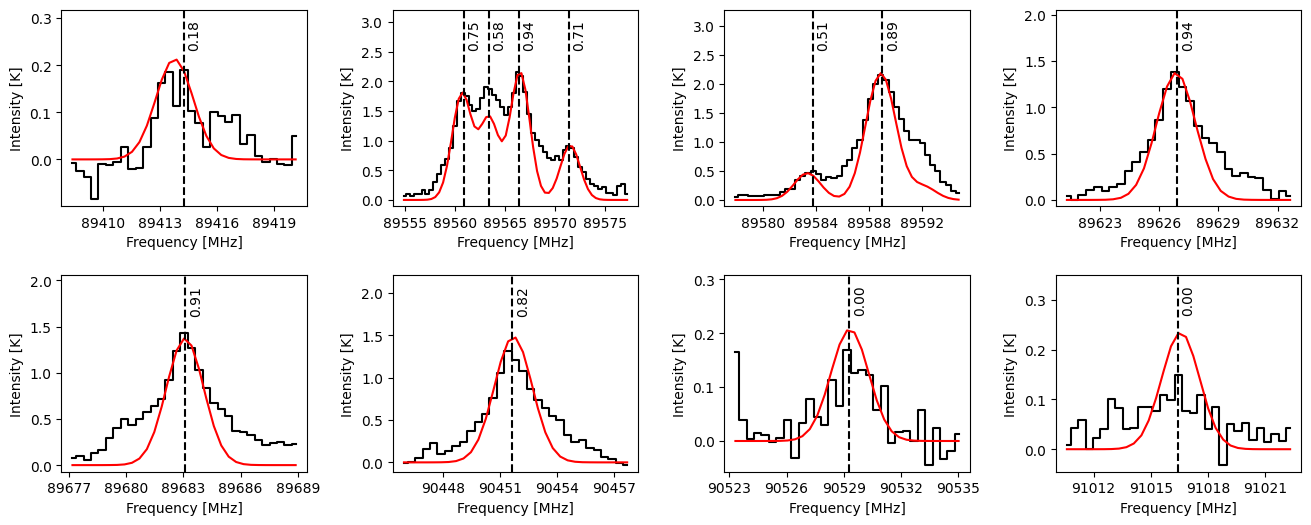

In [6]:
plot = spectuner.PeakPlot(freqs, delta_v=20)
# Plot the observed spectrum
plot.plot_spec_from_config(config, step_plot=True)
# Plot the model spectrum
plot.plot_spec(res.freq_data, res.get_T_pred(), color="r", ylim_factor=1.5)

# Plot the vertical lines and the scores
texts = ["{:.2f}".format(s) for s in props["score"]]
plot.vlines(freqs)
plot.vtexts(freqs, texts)


for ax in plot.axes.flat:
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("Intensity [K]")
plt.subplots_adjust(hspace=0.35, wspace=0.35)

## Checking properties in the spectroscopic database

We can also examine the transition properties associated with the identified lines. The following code block demonstrates how to load these properties. Note that ``sl_dict`` contains two frequency values for each transition:

- ``freq_rest``: Rest-frame frequencies of the transitions.
- ``freq``: Shifted frequencies corrected using the fitted $v_{\rm LSR}$.

In [7]:
# Setting need_qn=True allows to load the quantum numbers.
sl_db = spectuner.SQLSpectralLineDB(fname_db, need_qn=True)

# Load transition properties
sl_dict = res.query_sl_dict(sl_db, key=key, name=name)

The following code block visualizes the transitions along with their corresponding lower-state energies. Using the same method, we can also display the Einstein A coefficients for these transitions. 

Several important features become apparent:

1. The transition frequencies often differ from the identified peak positions.
2. Individual peaks may blend multiple transitions.
3. Some transitions have the same frequency.

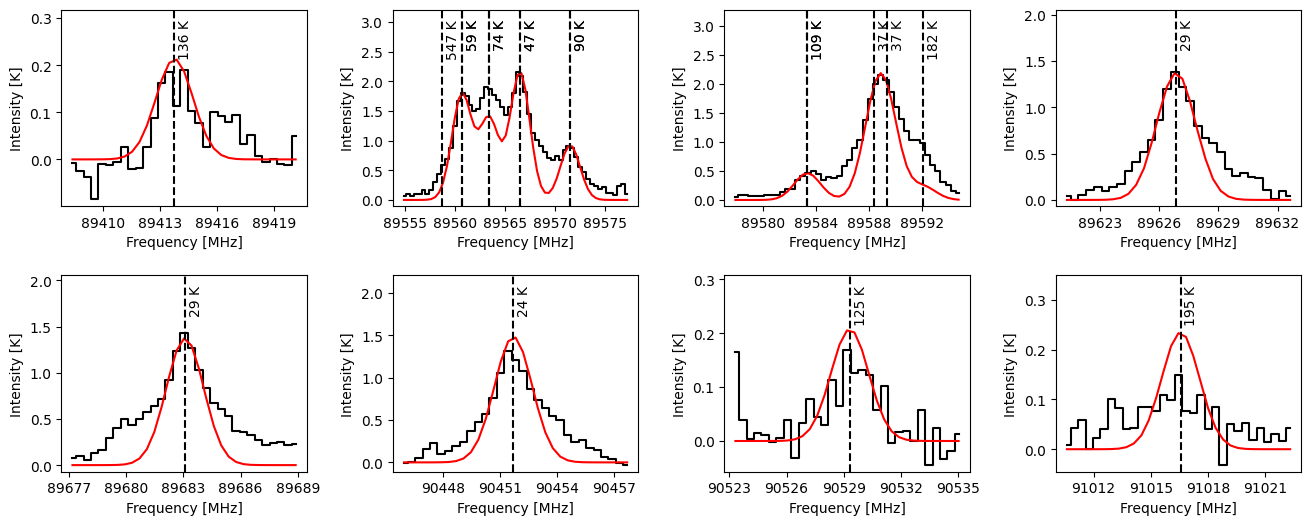

In [8]:
plot = spectuner.PeakPlot(freqs, delta_v=20)
# Plot the observed spectrum
plot.plot_spec_from_config(config, step_plot=True)
# Plot the model spectrum
plot.plot_spec(res.freq_data, res.get_T_pred(), color="r", ylim_factor=1.5)


# Plot the vertical lines and the scores
texts = ["{:.0f} K".format(s) for s in sl_dict["E_low"]]
plot.vlines(sl_dict["freq"])
plot.vtexts(sl_dict["freq"], texts)


for ax in plot.axes.flat:
    ax.set_xlabel("Frequency [MHz]")
    ax.set_ylabel("Intensity [K]")
plt.subplots_adjust(hspace=0.35, wspace=0.35)

We may further check the transitions in each windows. This can be done using ``assign_values_to_intervals`` as demonstrated in the code block below.  

In [9]:
inds_list = spectuner.assign_values_to_intervals(plot.bounds, sl_dict["freq"])
for i_window, inds in enumerate(inds_list):
    lower, upper = plot.bounds[i_window]
    print("{:.0f} - {:.0f} MHz:".format(lower, upper))
    for i_trans in inds:
        nu = sl_dict["freq_rest"][i_trans]
        E_low = sl_dict["E_low"][i_trans]
        qn_low = sl_dict["qn_low"][i_trans]
        print("  - nu = {:.0f} MHz, E_low = {:.0f} K, {}".format(nu, E_low, qn_low))

89408 - 89420 MHz:
  - nu = 89415 MHz, E_low = 136 K, ElecStateLabel = X; J = 24; Ka = 2; Kc = 22; 
89555 - 89577 MHz:
  - nu = 89560 MHz, E_low = 547 K, ElecStateLabel = X; J = 48; Ka = 6; Kc = 42; 
  - nu = 89562 MHz, E_low = 59 K, ElecStateLabel = X; J = 9; Ka = 6; Kc = 3; 
  - nu = 89562 MHz, E_low = 59 K, ElecStateLabel = X; J = 9; Ka = 6; Kc = 4; 
  - nu = 89565 MHz, E_low = 74 K, ElecStateLabel = X; J = 9; Ka = 7; Kc = 2; 
  - nu = 89565 MHz, E_low = 74 K, ElecStateLabel = X; J = 9; Ka = 7; Kc = 3; 
  - nu = 89568 MHz, E_low = 47 K, ElecStateLabel = X; J = 9; Ka = 5; Kc = 5; 
  - nu = 89568 MHz, E_low = 47 K, ElecStateLabel = X; J = 9; Ka = 5; Kc = 4; 
  - nu = 89573 MHz, E_low = 90 K, ElecStateLabel = X; J = 9; Ka = 8; Kc = 2; 
  - nu = 89573 MHz, E_low = 90 K, ElecStateLabel = X; J = 9; Ka = 8; Kc = 1; 
89578 - 89595 MHz:
  - nu = 89585 MHz, E_low = 109 K, ElecStateLabel = X; J = 9; Ka = 9; Kc = 1; 
  - nu = 89585 MHz, E_low = 109 K, ElecStateLabel = X; J = 9; Ka = 9; Kc = 0; 

## Checking optical depths


The [IdentResult](../api/identify.rst#spectuner.identify.IdentResult) class also provides a convenient method to compute the maximum optical depth for each transition. The code block below shows how to use it. 

In [10]:
tau = res.compute_tau_max(sl_db, key=key, name=name)

inds_list = spectuner.assign_values_to_intervals(plot.bounds, sl_dict["freq"])
for i_window, inds in enumerate(inds_list):
    lower, upper = plot.bounds[i_window]
    print("{:.0f} - {:.0f} MHz:".format(lower, upper))
    for i_trans in inds:
        nu = sl_dict["freq_rest"][i_trans]
        print("  - nu = {:.0f} MHz, tau = {:.2e}".format(nu, tau[i_trans]))

89408 - 89420 MHz:
  - nu = 89415 MHz, tau = 5.83e-04
89555 - 89577 MHz:
  - nu = 89560 MHz, tau = 4.11e-06
  - nu = 89562 MHz, tau = 2.44e-03
  - nu = 89562 MHz, tau = 2.44e-03
  - nu = 89565 MHz, tau = 1.87e-03
  - nu = 89565 MHz, tau = 1.87e-03
  - nu = 89568 MHz, tau = 2.95e-03
  - nu = 89568 MHz, tau = 2.95e-03
  - nu = 89573 MHz, tau = 1.26e-03
  - nu = 89573 MHz, tau = 1.26e-03
89578 - 89595 MHz:
  - nu = 89585 MHz, tau = 6.34e-04
  - nu = 89585 MHz, tau = 6.34e-04
  - nu = 89590 MHz, tau = 3.40e-03
  - nu = 89591 MHz, tau = 3.40e-03
  - nu = 89594 MHz, tau = 6.34e-04
89621 - 89633 MHz:
  - nu = 89628 MHz, tau = 3.76e-03
89677 - 89689 MHz:
  - nu = 89685 MHz, tau = 3.76e-03
90446 - 90458 MHz:
  - nu = 90453 MHz, tau = 4.06e-03
90523 - 90535 MHz:
  - nu = 90531 MHz, tau = 5.67e-04
91010 - 91022 MHz:
  - nu = 91018 MHz, tau = 6.43e-04
